<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: В каком пространстве градиентный бустинг совершает градиентный спуск? Какова размерность этого 
пространства?

В пространстве $R^M$, если $X  \in  R^{MxN}$, размерность которого равна размерности $y$ или объему обучающей выборки.

**Вопрос 2**: Почему бустинг над глубокими деревьями это плохая идея?

Потому что решающие деревья очень легко переобучаются. Переобученное дерево дает идеальный результат на обучающей выборке, но уже не так хорошо работает на тестовой.

**Вопрос 3**: Что предсказывает каждое дерево (что является признаками, а что целевой переменной?)

Каждый последующий алгоритм пытается уменьшить ошибку предыдущего. Каждое новое дерево предсказывает градиент, т. е. поправку к ответу, полученному на предыдущих шагах. Таким образом, цель каждого последующего алгоритма - уменьшить функцию ошибки, полученную для линейной комбинации предыдущих базовых алгоритмов.

<h1 align="center">Binary Boosting Implementation</h1> 

Давайте вспомним бустинг

#### Градиентный спуск

Самый простой метод минимизации функции, для оптимизации в каждый момент времени двигаемся по антиградиенту функции с каким-то шагом. 

$$w_{n+1} = w_n - s \cdot \frac{\partial f}{\partial w}$$

#### Градиентный бустинг

Теперь давайте представим, что на каждом шаге мы оптимизируем не параметры алгоритма $w$, а ответы нашего алгоритма $\hat{y}$.

**Обучение**: На каждом шаге, давайте предсказывать градиент на каждом объекте и "двигать" ответ в сторону улучшения (антиградиента).

**Алгоритм**:
- Первый алгоритм отвечает константу 
- Добавляем базовые алгоритмы $b_i$, $i = 1, .., N$:
    - $\hat{y} = \sum_{j=0}^{i-1} a_j b_j(x)$
    - Вычисляем градиент функции потерь ПО ОТВЕТАМ модели $g_{i-1} = \frac{\partial L(\hat{y},~~y)}{\partial \hat{y}}$ на каждом объекте  
    - Обучаем $b_i$ предсказывать текущий $g_{i-1}$ (Тут дерево не глубокое регрессионное дерево)
    - Дополняем композицию $\sum_{j=0}^{i-1} a_j b_j (x) + lr * b_i(x)$
    
    
#### Нужно реализовать двух классовый бустинг с логистической функцией потерь.     

**Функция потерь**:
Я вот думаю, что всем интересно какую-же функцию потерь выбрать $\mathcal{L}(\hat{y},y)=\log\left( 1 + e^{-\hat{y}y} \right)$

тут важный момент есть, даже не один
- $\hat{y}$ -- это ответ композиции, тоесть сумма ответов всех предыдущих деревьев
- Это скалярная функция и производная халява, но вот тут мы вам посчитали $$\frac{\partial \mathcal{L}}{\partial \hat{y}} = \frac{1}{1 + e^{-y\hat{y}}} \cdot (-ye^{-y\hat{y}})=-y\frac{1}{1 + e^{y\hat{y}}}$$

In [1]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
from copy import deepcopy
from utils import plot_surface
from scipy import special
from sklearn.tree import DecisionTreeRegressor
from sklearn import cross_validation, metrics
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier

warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
class BinaryBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators, lr=0.1):
        self.lr = lr
        self.n_estimators = n_estimators
    
    def loss_grad(self, original_y, pred_y):
        # Функция должна вернуть вектор длины = len(pred_y)
        # В каждом элементе вектора должно быть значение градиента dL(pred_y, original_y) / d pred_y[i]
        return -special.expit(-original_y * pred_y) * original_y # Градиент на каждом объекте
        
    def fit(self, X, original_y):
        # Храните базовые алгоритмы тут
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            grad = self.loss_grad(original_y, self._predict(X))
            # Настройте базовый алгоритм на градиент, это регрессия
            estimator = DecisionTreeRegressor(max_depth=5, random_state=1)
            estimator.fit(X, grad)
            self.estimators_.append(estimator)

        return self

    def _predict(self, X):
        # Эта штука как раз должна вернуть сумму ответов всех алгоритмов 
        # Не забудьте про ленинг рейт
        y_pred = np.sum( [ e.predict(X) for e in self.estimators_[:-1] ], axis=0 )
        if len(self.estimators_): y_pred = y_pred + self.lr * self.estimators_[len(self.estimators_)-1].predict(X)
        return y_pred
    
    def predict(self, X):
        # А тут на выходе должны быть классы, подумайте как это сделать
        y_pred = (self._predict(X) < 0) * 2 - 1
        return y_pred

<h1 align="center">Simple test</h1> 

In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=2,
                           n_informative=2, n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=70)
y = 2*(y-0.5)

0.882


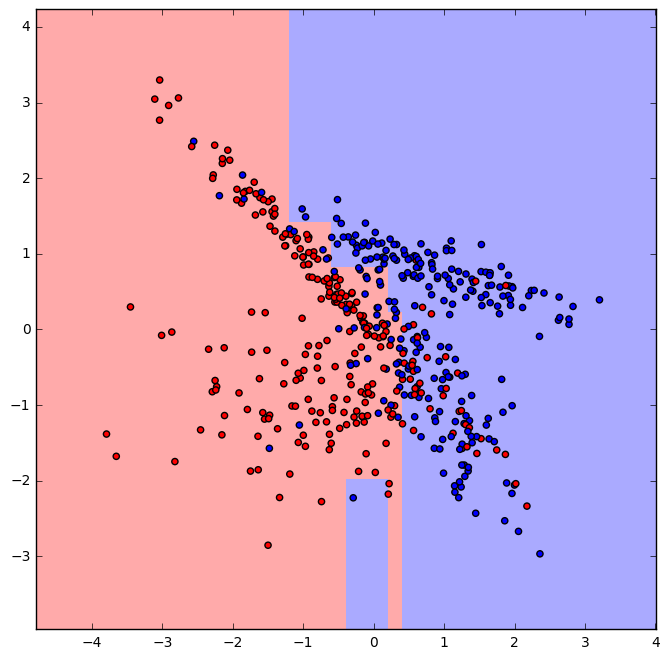

In [20]:
clf = BinaryBoostingClassifier(n_estimators=100).fit(X, y)
skl_clf = GradientBoostingClassifier(n_estimators=100).fit(X, y)

#My gradient boosting
predictions = clf.predict(X)
plot_surface(X, y, clf)
print metrics.accuracy_score(y, predictions)
#SKL gradient boosting
#predictions = skl_clf.predict(X)
#plot_surface(X, y, skl_clf)
#print metrics.accuracy_score(y, predictions)
#print y[:100]
#print predictions[:100]

<h1 align="center">Adult test</h1> 

#### Скачайте https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [21]:
adult = pd.read_csv(
    './data/adult.data', 
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"], 
    header=None, na_values="?")
adult = pd.get_dummies(adult)
adult["Target"] = adult["Target_ >50K"]

In [22]:
X, y = adult[adult.columns[:-3]].values, adult[adult.columns[-1]].values
y = 2*(y-0.5)

In [32]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,
                                                                             train_size = 0.3,
                                                                             test_size = 0.3,
                                                                             random_state = 242)
my_clf  = BinaryBoostingClassifier(n_estimators=100).fit(X_train, y_train)
skl_clf = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [33]:
my_predictions = my_clf.predict(X_test)
print "MY:", metrics.accuracy_score(y_test, my_predictions)
skl_predictions = skl_clf.predict(X_test)
print "SKL:", metrics.accuracy_score(y_test, skl_predictions)

MY: 0.850445286109
SKL: 0.868666188965


<h1 align="center">Сдача ДЗ</h1> 

Заполните форму https://goo.gl/forms/sPE6gpRDNTOXQai12 
    - Качество вашего алгоритма на adult, один знак после запятой, без округления (0.86 -> 0.8 и тд) точность
    - BinaryBoostingClassifier.loss_grad ([-1, 1, 1], [-1, 1, -1]).sum()

In [17]:
my_clf.loss_grad(np.array([-1, 1, 1]), np.array([-1, 1, -1])).sum()

-0.7310585786300049